In [1]:
import jax.numpy as jnp
from jax import grad, vmap, jit, random, lax

import kagglehub
import matplotlib.pyplot as plt
import numpy as np

# path = kagglehub.dataset_download("hojjatk/mnist-dataset")  # download mnist
path = '/home/tibless/.cache/kagglehub/datasets/hojjatk/mnist-dataset/versions/1'
key = random.PRNGKey(239)  # 239; 412
print(f'mnsit at: {path}')

mnsit at: /home/tibless/.cache/kagglehub/datasets/hojjatk/mnist-dataset/versions/1


In [2]:
# load mnist

import os
import struct
import numpy as np

def read_idx(filename):
    """
    Read MNIST data from file using idx format.

    Return
    ------
    np.ndarray
    """
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

TRAIN = 60000
TEST  = 10000
train_images = read_idx(os.path.join(path, 'train-images.idx3-ubyte'))
train_labels = read_idx(os.path.join(path, 'train-labels.idx1-ubyte'))
test_images = read_idx(os.path.join(path, 't10k-images.idx3-ubyte'))
test_labels = read_idx(os.path.join(path, 't10k-labels.idx1-ubyte'))

# shuffle_kernel = np.random.permutation(np.arange(60000))
# train_images = train_images[shuffle_kernel][:TRAIN]
# train_labels = train_labels[shuffle_kernel][:TRAIN]

label = 5
train_images = train_images[train_labels == label]
test_images = test_images[test_labels == label]

print("训练图像数据大小: ", train_images.shape)
print("训练标签数据大小: ", train_labels.shape)
print("测试图像数据大小: ", test_images.shape)
print("测试标签数据大小: ", test_labels.shape)

训练图像数据大小:  (5421, 28, 28)
训练标签数据大小:  (60000,)
测试图像数据大小:  (892, 28, 28)
测试标签数据大小:  (10000,)


In [3]:
X_train = jnp.array(train_images.reshape(train_images.shape[0], -1)) / 255.  # normalization to accelerate training & convergency
X_test = jnp.array(train_images.reshape(train_images.shape[0], -1)) / 255.
X = jnp.concatenate((X_train, X_test), axis=0)

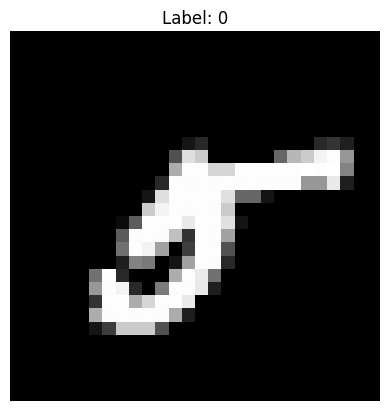

In [4]:
ix = np.random.randint(0, train_images.shape[0])
plt.imshow(train_images[ix], cmap='gray')
plt.title(f"Label: {train_labels[ix]}")
plt.axis('off')  # 不显示坐标轴
plt.show()

In [5]:
import jax.numpy as jnp
from jax import random

from plugins.minitorch.initer import Initer
from plugins.minitorch.optimizer import RawGD, Adam
from plugins.minitorch.loss import Loss
from plugins.minitorch.nn import Dense
from plugins.minitorch.utils import sigmoid

KEY = random.PRNGKey(324)

class BCE_KLD(Loss):
    def __init__(self, f):
        super(BCE_KLD, self).__init__(f)

    def get_loss(self):
        def _loss(params, x, y, key, epsilon = 1e-9):
            x_recon, mu, logvar = self.f(params, x, key)
            x_recon_clip = jnp.clip(x_recon, epsilon, 1. - epsilon)  # clip here is very important, or you will get Nan when you training.

            bce = -jnp.sum(y*jnp.log(x_recon_clip) + (1 - y)*jnp.log(1 - x_recon_clip), axis=1)
            kld = -0.5 * jnp.sum(1 + logvar - mu**2 - jnp.exp(logvar), axis=1)

            return jnp.mean(bce + 2 * kld)

        return jit(_loss)

    def get_embed_loss(self):
        raise ValueError(f'this method is not accessable for BCE_KLD')


class VAE:
    def __init__(self, lr=0.01, batch_size=32):
        self.config = {
            'fc4relu:0': Dense.get_linear(input_dim=784, output_dim=512),
            'fc4relu:1': Dense.get_linear(input_dim=512, output_dim=128),
            'fc4relu:2mu': Dense.get_linear(input_dim=128, output_dim=32),      # µ
            'fc4relu:2logvar': Dense.get_linear(input_dim=128, output_dim=32),  # log(σ²) ⊂ (-∞, +∞), so we do not need to constrain output of Linear Layer.
            'fc4relu:3': Dense.get_linear(input_dim=32, output_dim=128),
            'fc4relu:4': Dense.get_linear(input_dim=128, output_dim=512),
            'fc4relu:5': Dense.get_linear(input_dim=512, output_dim=784),
        }

        initer = Initer(self.config, key=random.PRNGKey(42))
        self.optr = Adam(initer(), lr=lr, batch_size=batch_size)
        self.batch_size = batch_size
        self.lossr = BCE_KLD(self.forward)

    def forward(self, params, x, key):
        res = Dense.linear(x, params['fc4relu:0'])
        res = jnp.maximum(0, res)
        
        res = Dense.linear(res, params['fc4relu:1'])
        res = jnp.maximum(0, res)
        
        mu = Dense.linear(res, params['fc4relu:2mu'])
        logvar = Dense.linear(res, params['fc4relu:2logvar'])

        z_sample = random.normal(key, logvar.shape) * jnp.exp(0.5*logvar) + mu  # reparameterize

        res = Dense.linear(z_sample, params['fc4relu:3'])
        res = jnp.maximum(0, res)
        
        res = Dense.linear(res, params['fc4relu:4'])
        res = jnp.maximum(0, res)

        res = Dense.linear(res, params['fc4relu:5'])
        res = sigmoid(res)

        return res, mu, logvar

    def generate(self, random_state):
        z_sample = random.normal(random.PRNGKey(random_state), (64, 32))

        res = Dense.linear(z_sample, self.optr.get_params()['fc4relu:3'])
        res = jnp.maximum(0, res)
        
        res = Dense.linear(res, self.optr.get_params()['fc4relu:4'])
        res = jnp.maximum(0, res)
        
        res = Dense.linear(res, self.optr.get_params()['fc4relu:5'])
        return sigmoid(res)

    def fit(self, x_train, epoches=100):
        _loss = self.lossr.get_loss()
        self.optr.open(_loss, x_train, x_train, key=KEY)

        loss = []

        for cnt in range(epoches):
            loss.append(_loss(self.optr.get_params(), x_train[:self.batch_size], x_train[:self.batch_size], key=KEY))

            self.optr.update()
            if (cnt + 1) % 50 == 0:
                print(f'>> epoch: {cnt + 1}, train loss: {loss[-1]}')

        return loss

In [6]:
batch_size = 256
learning_rate = 0.003
epochs = 400

model = VAE(lr=learning_rate, batch_size=batch_size)

loss = model.fit(x_train=X, epoches=epochs)

[*] oprimizer opened with 42 batches with batch size 256.
>> epoch: 50, train loss: 114.82430267333984
>> epoch: 100, train loss: 110.83079528808594
>> epoch: 150, train loss: 109.9316635131836
>> epoch: 200, train loss: 109.40091705322266
>> epoch: 250, train loss: 107.9001235961914
>> epoch: 300, train loss: 107.81982421875
>> epoch: 350, train loss: 106.0837173461914
>> epoch: 400, train loss: 107.50812530517578


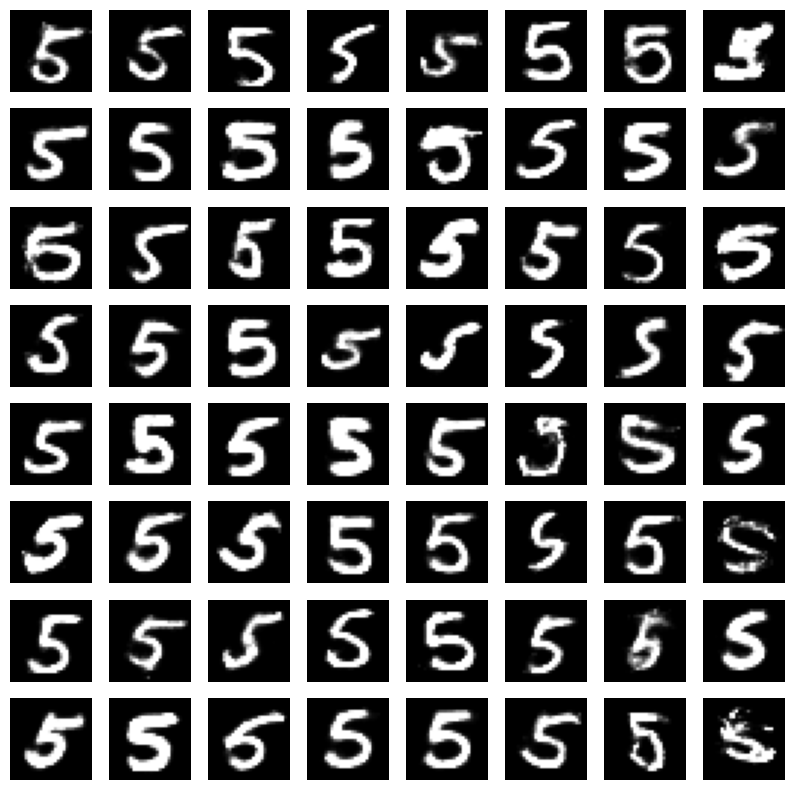

In [10]:
import matplotlib.pyplot as plt
import numpy as np

res = model.generate(np.random.randint(0, 10000))*255

def plot_samples(samples):
    fig, axes = plt.subplots(8, 8, figsize=(10, 10))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(samples[i].reshape(28, 28).astype(jnp.int8), cmap='gray')
        ax.axis('off')
    plt.show()

plot_samples(res)